# Neural ODE's

Given the vector quantity of interest $\mathbf{y}(t), t \in [0, T]$ we are considering a generic ODE of the shape:

$$
\frac{d\mathbf{y}(t)}{dt} = f(\mathbf{y}(t), t, \theta)
$$

where $f$ is a neural network with parameters $\theta$. Furthermore we have the true unknown function $f^*$, which we are trying to approximate. As in many machine learning problems, we have a dataset of observations $\mathbf{y}^*(t)$, $t \in [0, T]$ which we can use to train our model. In some cases the observations are noisy, in which case we can write $\mathbf{y}^*(t) = \mathbf{y}(t) + \epsilon(t)$, where $\epsilon(t)$ is a noise term. Let us model a simple ODE and plot the noisy observations.


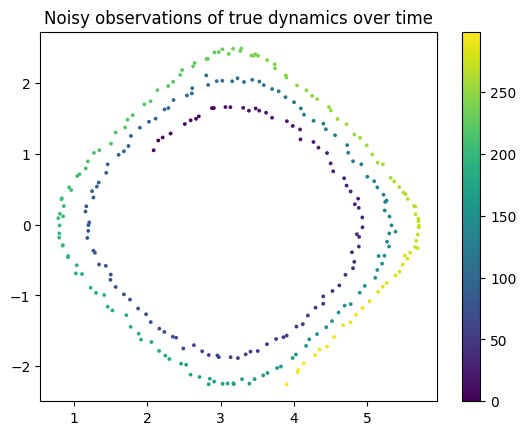

In [79]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

def f_star(y):
    return jnp.sin(jnp.array([y[1], y[0]]))

def solve(f, y_0, dt, n):
    y_hist = jnp.zeros((n, 2))
    y = y_0
    for i in range(n):
        y = f(y) * dt + y
        y_hist = y_hist.at[i, :].set(y)

    return y_hist

y_star_0 = jnp.array([2.0, 1.0])
dt = 0.1
n = 300
y_star = solve(f_star, y_star_0, dt, n)
noise = 0.03 * jax.random.normal(jax.random.PRNGKey(0), (n, 2))
y_star += noise

plt.scatter(y_star[:, 0], y_star[:, 1], c=jnp.arange(n), s=3)
plt.colorbar()
plt.title("Noisy observations of true dynamics over time")
plt.show()


Now we are interested in finding $\theta$ such that $\mathbf{y}(t)$ is close or equal to $\mathbf{y}^*(t)$, where $\mathbf{y}^*(t)$ is the true solution of the ODE. Hence we can formulate our task as a loss function

$$
\mathcal{L} = \int_0^T \left\| \mathbf{y}(t) - \mathbf{y}^*(t) \right\|^2 dt
$$

which we wish to minimize using a gradient-based optimization algorithm such as Adam. Therefore we need to find the gradient of the loss function with respect to the parameters $\theta$.

$$
\frac{d\mathcal{L}}{d\theta} = \int_0^T \frac{d\mathbf{y}(t)}{d\theta} \cdot \left( \mathbf{y}(t) - \mathbf{y}^*(t) \right) dt
$$

With todays AD frameworks, this is actually pretty easy to do.

In [80]:
import optax
from typing import NamedTuple
from functools import partial

# we define the parameters of a simple MLP
class mlp_theta(NamedTuple):
    w0: jnp.ndarray
    b1: jnp.ndarray
    w1: jnp.ndarray
    b2: jnp.ndarray

# we define the forward pass of the MLP
def f(y, theta: mlp_theta):
    y = jnp.tanh(y @ theta.w0 + theta.b1)
    y = jnp.tanh(y @ theta.w1 + theta.b2)
    return y

# we define the loss function
def loss(y, y_star):
    return jnp.mean((y - y_star) ** 2)

# we define the solver and loss function
@partial(jax.jit, static_argnums=(3, 4))
def solve_and_loss(y_0, f, y_star, dt, n):
    y = solve(f, y_0, dt, n)
    return loss(y, y_star)

y_0 = jnp.array([0.0, 0.0])
d_solve_loss = jax.value_and_grad(solve_and_loss, argnums=1)

# we initialize the parameters of the MLP
theta = mlp_theta(
    w0=jnp.zeros((2, 2)),
    b1=jnp.zeros(2),
    w1=jnp.zeros((2, 2)),
    b2=jnp.zeros(2))

# we define the optimizer
optimizer = optax.adam(1e-2)
optimizer_state = optimizer.init(theta)

# we train the model
for i in range(10):
    f_theta = jax.tree_util.Partial(f, theta)
    loss, grad = d_solve_loss(y_0, f_theta, y_star, dt, n)
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    theta = optax.apply_updates(theta, updates)
    print(f"Loss at iteration {i}: {loss}")


AttributeError: DynamicJaxprTracer has no attribute w0